In [1]:
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics
from asap.annotation import ASAPNMF
import asapc
import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc
from sklearn.preprocessing import StandardScaler
# import logging


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id



tree_max_depth = 10
num_factors = 10
batch_size = 10000
batch_iteration = 1


dl = DataSet(sample_in,sample_out)
sample_list = dl.get_samplenames()
dl.initialize_data(sample_list,batch_size)


print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/osteosarcoma/osteosarcoma
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/osteosarcoma/osteosarcoma


In [2]:
model = np.load(sample_out+'_10000_dcnmf.npz')

In [3]:
dl.batch_label = [ x for x in model['batch_label']]
dl.barcodes = [ x for x in model['barcodes']]

In [4]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = dl.genes
df_theta = pd.DataFrame(model['corr'])
df_theta.index = dl.barcodes

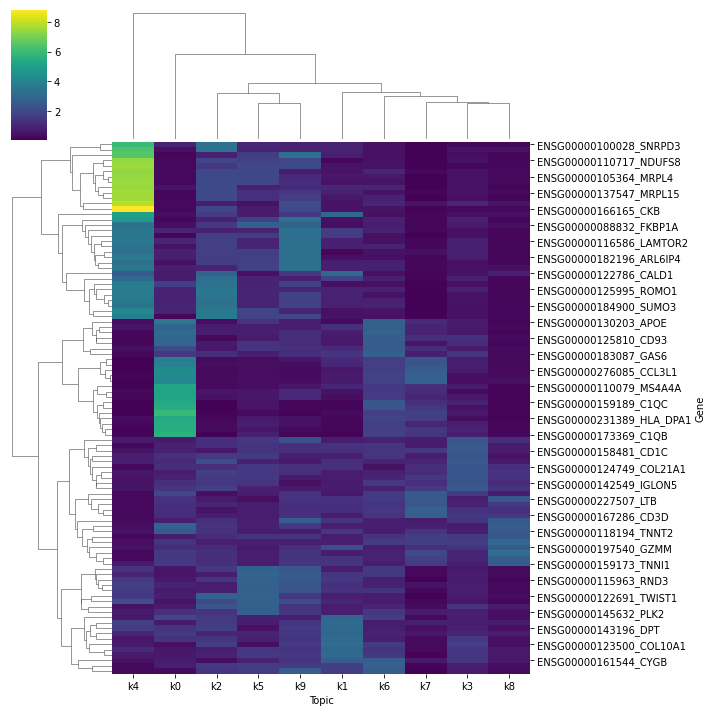

In [5]:
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>20] = 20
sns.clustermap(df_top.T,cmap='viridis')

In [6]:
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_umap= pd.DataFrame()
df_umap['cell'] = dl.barcodes
# df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

scaler = StandardScaler()
scaled = scaler.fit_transform(df_theta.to_numpy())
kmeans = KMeans(n_clusters=10, init='k-means++',random_state=0).fit(scaled)
df_umap['topic_bulk'] = kmeans.labels_

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.5,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sample_out+'_theta_umap.csv')
# df_umap.columns = ['cell','umap1','umap2']


,cell,topic_bulk,umap1,umap2
0,AAACCTGAGACTCGGA-1_BC10,2,10.454432,7.487066
1,AAACCTGAGACTTGAA-1_BC10,2,7.850137,5.046643
2,AAACCTGAGCTCCTTC-1_BC10,9,4.887267,4.913274
3,AAACCTGAGGAACTGC-1_BC10,5,9.438195,6.687389
4,AAACCTGAGGAGTCTG-1_BC10,7,2.267483,2.121064
...,...,...,...,...
9989,ACCTTTATCCACTGGG-1_BC6,3,-2.368376,7.013808
9990,ACCTTTATCCCACTTG-1_BC6,6,4.027594,-3.507941
9991,ACCTTTATCCGATATG-1_BC6,3,-1.372205,9.952735
9992,ACCTTTATCCGCGTTT-1_BC6,2,4.648561,7.275844


Text(0, 0.5, 'UMAP2')

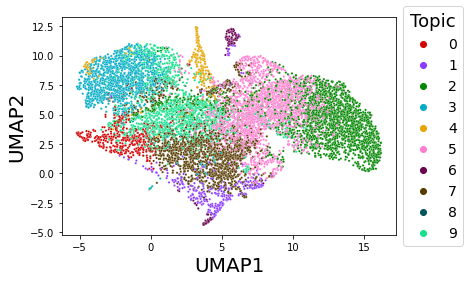

In [7]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

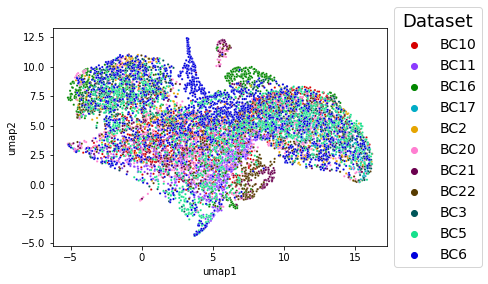

In [8]:
df_umap['batch'] = [x.split('_')[1]for x in df_umap['cell']]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['batch'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='batch',s=5,palette=cp,legend=True)
plt.legend(title='Dataset',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [9]:
pd.Series([x for x in model['batch_label']]).value_counts()

BC5     1690
BC6     1667
BC10    1336
BC11    1028
BC20     848
BC16     780
BC22     706
BC3      673
BC21     503
BC2      455
BC17     308
dtype: int64

In [10]:
sum=0
for values in dl.sample_batch_size.values():sum+=values
sum

9994

In [11]:
df_umap.batch.value_counts()

BC5     1690
BC6     1667
BC10    1336
BC11    1028
BC20     848
BC16     780
BC22     706
BC3      673
BC21     503
BC2      455
BC17     308
Name: batch, dtype: int64

In [12]:
dl.shape

[32864, 130761]

In [13]:
dl.sample_batch_size

{'BC10': 1336,
 'BC11': 1028,
 'BC16': 780,
 'BC17': 308,
 'BC2': 455,
 'BC20': 848,
 'BC21': 503,
 'BC22': 706,
 'BC3': 673,
 'BC5': 1690,
 'BC6': 1667}

In [14]:
df_theta.shape

(9994, 10)

In [15]:
dl.run_full_data

False